In [1]:
from google.colab import drive

In [2]:
drive.mount('/content/MyDrive')

Mounted at /content/MyDrive


In [3]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model

In [4]:
# load vgg16 model for extraction of image features
vgg = VGG16()

553476096/553467096 [==============================] - 4s 0us/step


In [5]:
# we need only image features and not the predictions so i will restructure 'vgg'
restructured_model = Model(inputs=vgg.inputs, outputs=vgg.layers[-2].output)

In [6]:
# these both the properties are taken from prepocessing python notebook
max_length = 39
vocab_size = 9114

In [7]:
from tensorflow.keras.layers import LSTM, Embedding, Dense, Dropout, Input, add

In [8]:
# define input for image features
input1 = Input(shape=(4096,))
x1 = Dropout(0.5)(input1)
x1 = Dense(256, activation='relu')(x1)

In [9]:
# define input for captions
input2 = Input(shape=(max_length,))
x2 = Embedding(vocab_size, 256, mask_zero=True)(input2)
x2 = Dropout(0.5)(x2)
x2 = LSTM(256)(x2)

In [10]:
# define output for models
output1 = add([x1, x2])
y = Dense(256, activation='relu')(output1)
y = Dense(vocab_size, activation='softmax')(y)

In [11]:
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

In [12]:
# define final model
model = Model(inputs=[input1, input2], outputs=y)

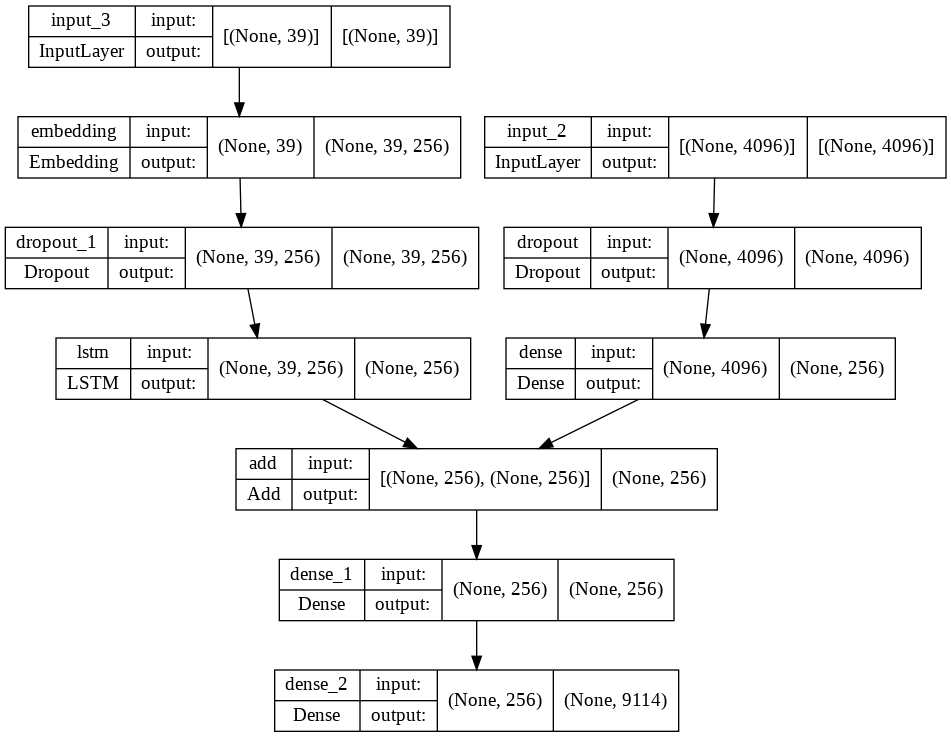

In [13]:
plot_model(model, show_shapes=True)

In [14]:
import pickle

In [15]:
with open('/content/MyDrive/MyDrive/datasets/image_features.pkl', 'rb') as f:
  image_features = pickle.load(f)

In [16]:
with open('/content/MyDrive/MyDrive/datasets/all_captions.pkl', 'rb') as f:
  all_captions = pickle.load(f)

In [17]:
with open('/content/MyDrive/MyDrive/datasets/traindataset.pkl', 'rb') as f:
  traindataset = pickle.load(f)

In [18]:
with open('/content/MyDrive/MyDrive/datasets/testdataset.pkl', 'rb') as f:
  testdataset = pickle.load(f)

In [19]:
with open('/content/MyDrive/MyDrive/datasets/captions.pkl', 'rb') as f:
  captions = pickle.load(f)

In [20]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [21]:
tokenizer = Tokenizer()

In [22]:
tokenizer.fit_on_texts(all_captions)

In [23]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import numpy as np
from tqdm.notebook import tqdm

In [24]:
def datamanager(captions, image_features, tokenizer, max_length, vocab_size, batch_size):
  while True:
    
    input1, input2, output, count = [], [], [], 0
    
    for image_id in image_features.keys():
      
      currentimagecaptions = captions[image_id]
      count += 1

      for caption in currentimagecaptions:

        sequence = tokenizer.texts_to_sequences([caption])[0]

        for i in range(len(sequence)-1):

          input_seq, output_seq = sequence[:i+1], sequence[i+1]

          input_seq = pad_sequences([input_seq], maxlen=max_length)[0]

          output_seq = to_categorical(output_seq, num_classes=vocab_size)

          input1.append(image_features[image_id][0])

          input2.append(input_seq)

          output.append(output_seq)
      
      if count==batch_size:
        yield [np.array(input1), np.array(input2)], np.array(output)

        input1, input2, output, count = [], [], [], 0

In [25]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy')

In [26]:
epochs = 20
batch_size = 64
steps = len(traindataset) // batch_size

for i in tqdm(range(epochs)):

  trainingdata = datamanager(captions, image_features, tokenizer, max_length, vocab_size, batch_size)

  model.fit(trainingdata, epochs=1, verbose=1, steps_per_epoch=steps)


  0%|          | 0/20 [00:00<?, ?it/s]

113/113 [==============================] - 43s 384ms/step - loss: 2.0694


In [27]:
# save the model
# model.save('/content/model.h5')

In [28]:
def map_to_word(idx, tokenizer):
  for word, index in tokenizer.word_index.items():
    if idx == index:
      return word
  return None

In [29]:
def caption_predictor(model, image, tokenizer, max_length):
  
  predictedcaption = 'startsentence'

  for i in range(max_length):
    sequence = tokenizer.texts_to_sequences([predictedcaption])[0]

    sequence = pad_sequences([sequence], maxlen=max_length)

    predictions = model.predict([image, sequence])

    index = np.argmax(predictions)

    predictedword = map_to_word(index, tokenizer)

    if predictedword is None or predictedword == 'endsentence':
      break

    predictedcaption += ' ' + predictedword

  return predictedcaption


In [30]:
# evaluate the model on bleu score
from nltk.translate.bleu_score import corpus_bleu

In [31]:
actual, predicted = [], []

for image_id in tqdm(testdataset):

  image_feature = image_features[image_id]

  prediction = caption_predictor(model, image_feature, tokenizer, max_length)

  actual.append(captions[image_id])

  predicted.append(prediction)


  0%|          | 0/810 [00:00<?, ?it/s]

In [32]:
corpus_bleu(actual, predicted, weights=(0.3, 0.7))

0.7865203341684192

In [33]:
corpus_bleu(actual, predicted, weights=(0.5, 0.5))

0.8110991732726539

In [34]:
corpus_bleu(actual, predicted, weights=(0.25, 0.75))

0.7804928953697836

In [35]:
corpus_bleu(actual, predicted, weights=(0.4, 0.6))

0.7987152138316487

In [36]:
from tensorflow.keras.utils import load_img, img_to_array
import os
import cv2 as cv
import matplotlib.pyplot as plt
%matplotlib inline

In [37]:
# for images in os.listdir('/content/'):

#   if os.path.isfile(images):

#     os.remove(images)

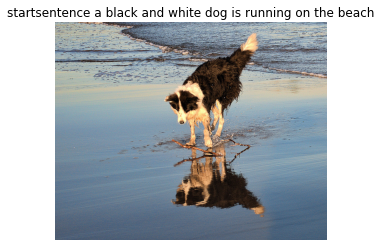

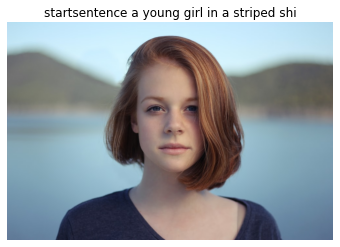

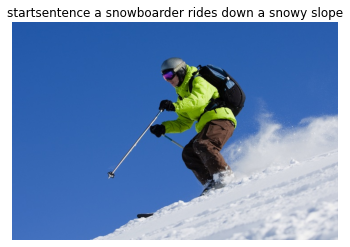

In [40]:
for images in os.listdir('/content/'):

  if os.path.isfile(images):

    randomimage = load_img(images, target_size=(224, 224))

    randomimage = img_to_array(randomimage)

    randomimage = randomimage.reshape((1,) + randomimage.shape)

    imagefeature = restructured_model.predict(randomimage)

    predictedcaption = caption_predictor(model, imagefeature, tokenizer, max_length)

    randomimage = cv.imread(images)
    
    randomimage = cv.cvtColor( randomimage, cv.COLOR_BGR2RGB)

    plt.imshow(randomimage)
    
    plt.title(predictedcaption)
    
    plt.axis('off')
    
    plt.savefig(f'predicted{images}')

    plt.show()

    print('\n\n')

In [39]:
model.save('model.h5')